In [2]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
from scipy import signal as sp
from tqdm import tqdm
from scipy.fft import fft, fftfreq
import numpy
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [3]:
wav_path = "wav2"
wav_list = os.listdir(wav_path)
print(wav_list)

['unpeeled_3.wav', 'unpeeled_2.wav', 'unpeeled_0.wav', 'unpeeled_1.wav', 'unpeeled_5.wav', 'unpeeled_4.wav', 'unpeeled_6.wav', 'unpeeled_7.wav', 'peeled_9.wav', 'peeled_8.wav', 'peeled_5.wav', 'peeled_4.wav', 'peeled_6.wav', 'peeled_7.wav', 'peeled_3.wav', 'peeled_2.wav', 'peeled_0.wav', 'peeled_1.wav', 'unpeeled_9.wav', 'unpeeled_8.wav']


In [4]:
num_data = len(wav_list)

SIGNAL_LENGTH = 261880
SAMPLE_RATE = 44100

signal_list = np.zeros((num_data, SIGNAL_LENGTH))
normalized_signal = np.zeros((num_data, SIGNAL_LENGTH))

label = np.zeros(num_data)

for i, wav in enumerate(tqdm(wav_list)):
    wav_full_path = os.path.join(wav_path, wav)
    spf = wave.open(wav_full_path, "r")
    # Extract Raw Audio from Wav File
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, "int16")
    signal = np.resize(signal, SIGNAL_LENGTH)
    signal = sp.medfilt(signal, 99)
    signal_list[i, :] = signal
    normalized_signal[i, :] = np.int16((signal/ signal.max())*32767)
    _label = 0 if wav.split('_')[0]=='unpeeled' else 1
    #print(_label)
    label[i] = _label

  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/2z/346pf_1n4lq7qq23h4pvhbw00000gn/T/ipykernel_47192/3232192955.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(signal, "int16")
100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


In [5]:
def visualize(signal_list=None) -> None:
    # signal_list is a list of signals(np array)
    # If not specify the signals in the input arguments, will use self. signal_list by default
    for signal in signal_list:
        plt.figure(1)
        plt.title("Signal Wave...")
        plt.plot(signal)
        plt.show()

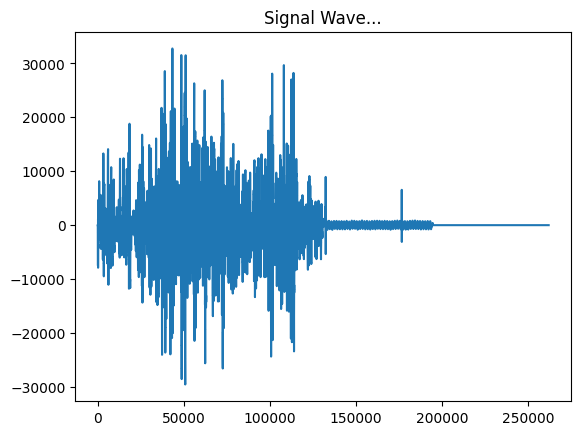

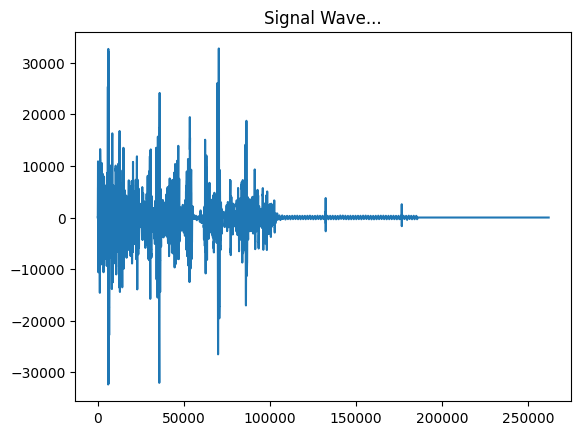

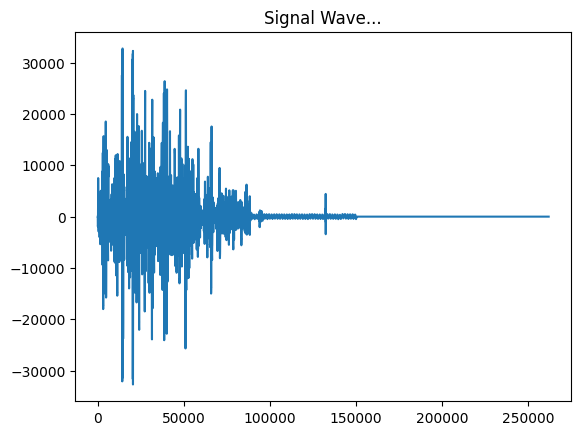

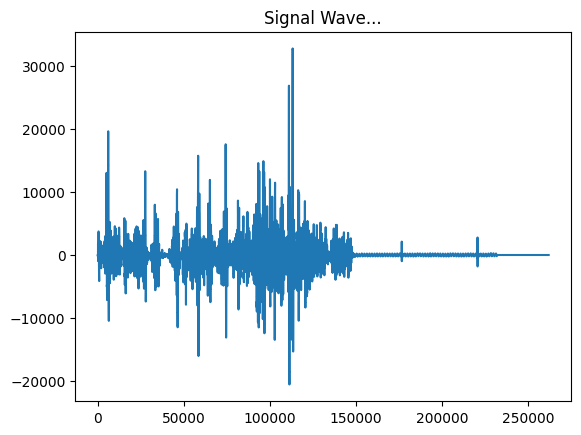

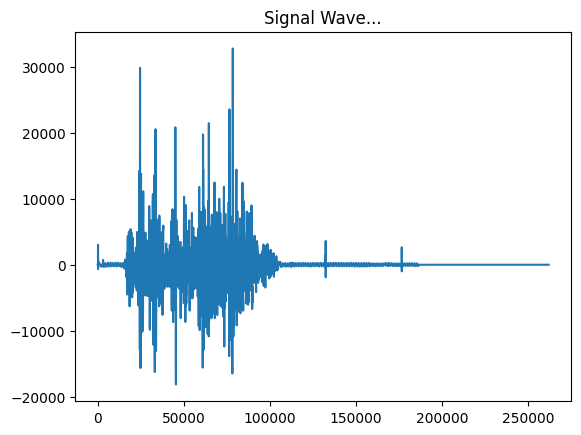

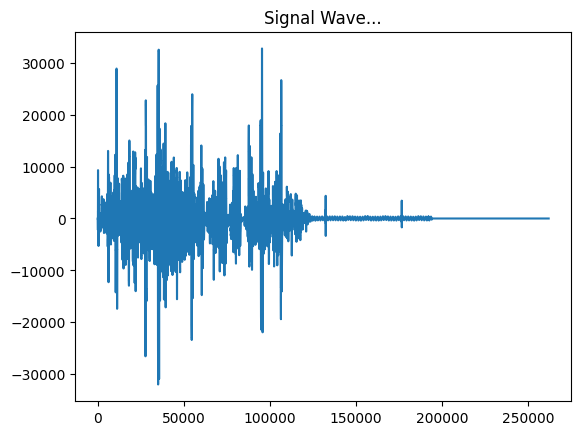

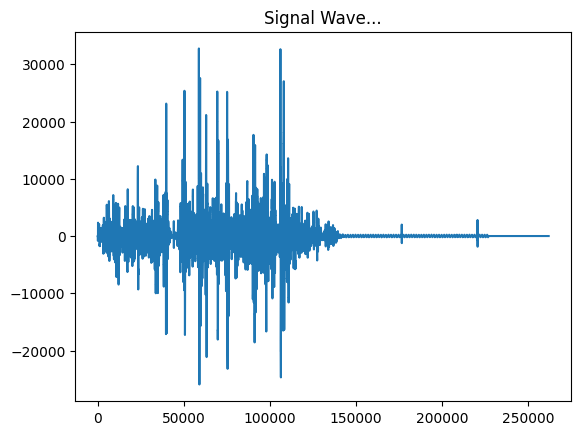

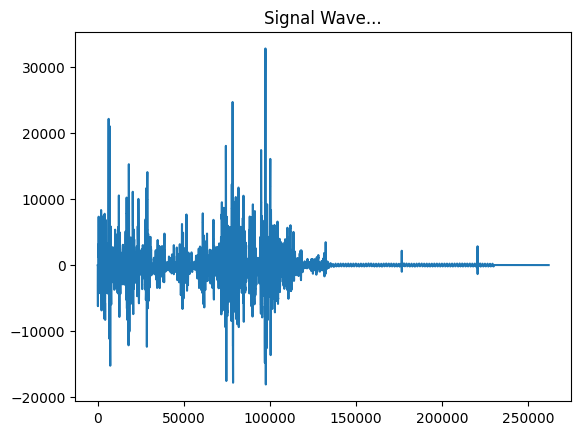

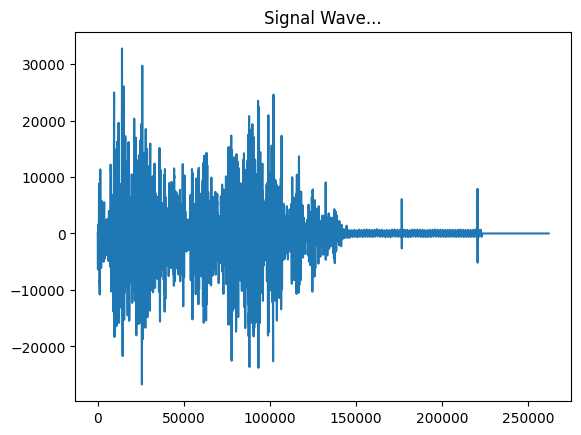

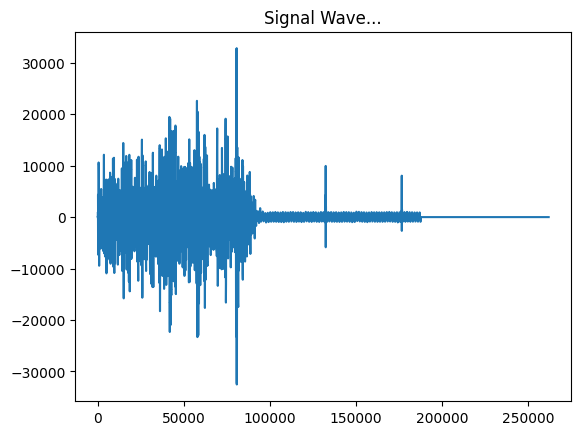

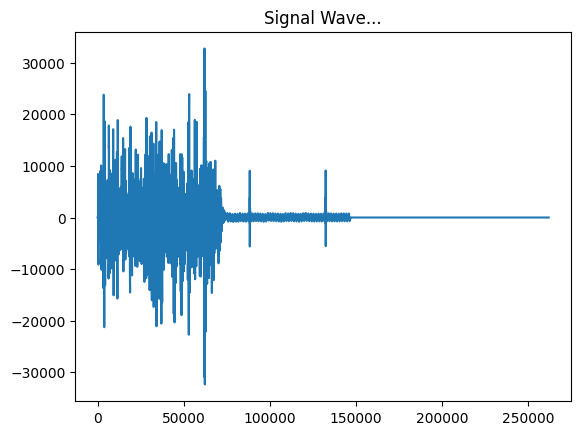

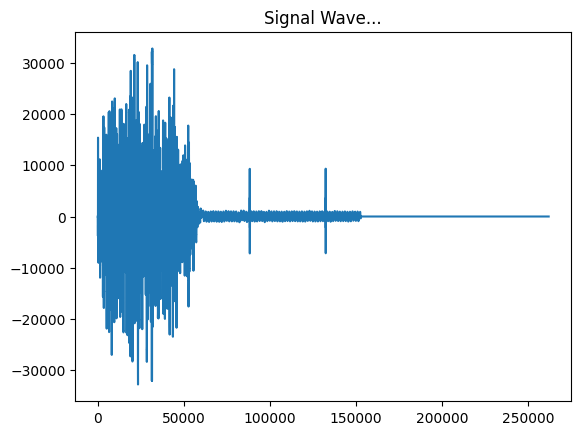

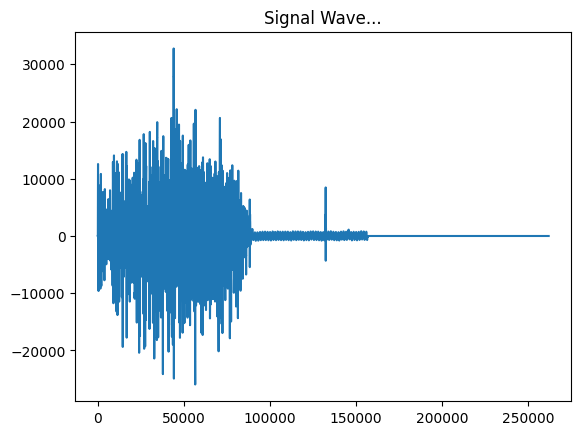

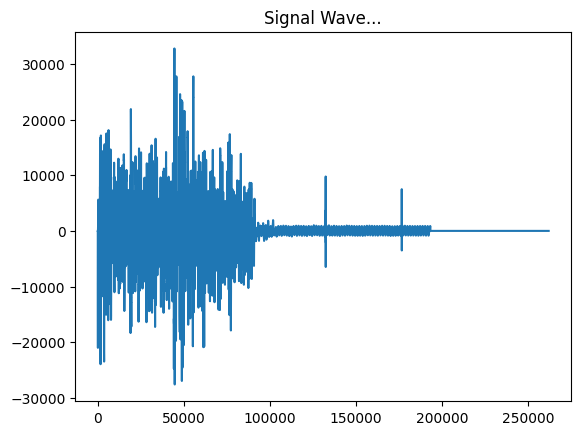

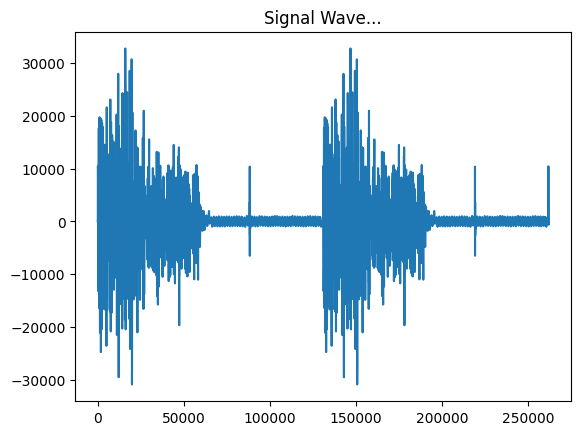

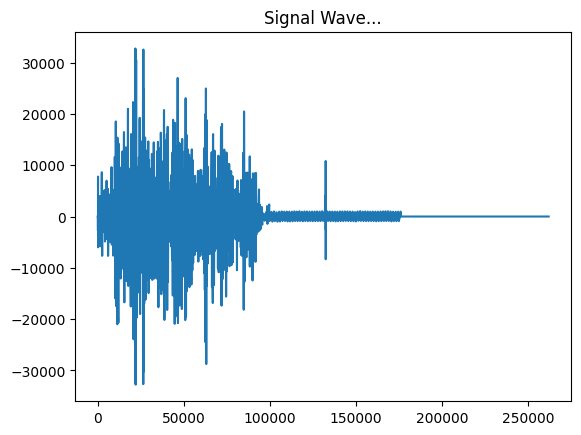

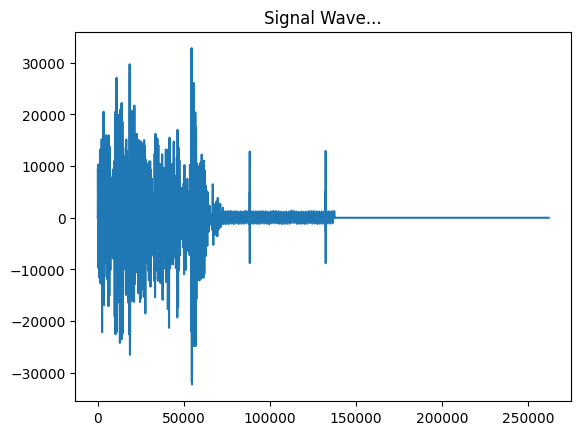

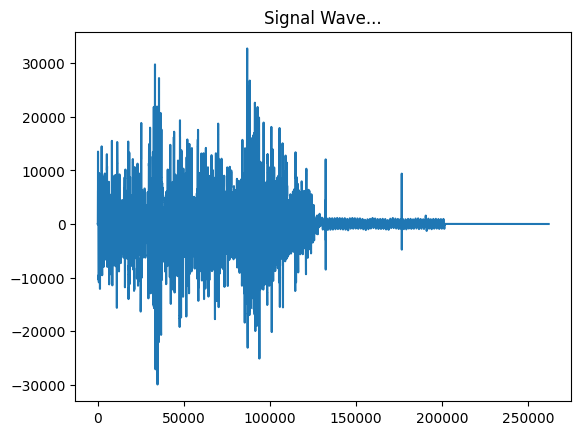

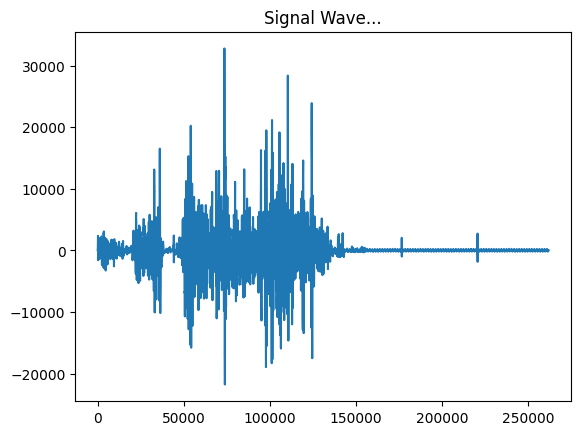

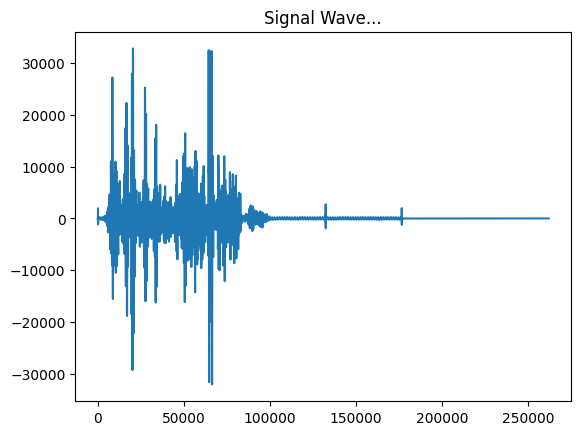

In [6]:
visualize(normalized_signal)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(normalized_signal, label, test_size=0.4, random_state=5)

In [8]:
print('fitting...')
clf = SVC(C=600, gamma=100)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("acc=%0.3f" % acc)

fitting...
acc=0.500


In [9]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

In [10]:
SIGNAL_LENGTH = 261890
new_siglist = np.zeros((len(signal_list), SIGNAL_LENGTH))
for i, sig in enumerate(signal_list):
    new_siglist[i, :] = smooth(sig)

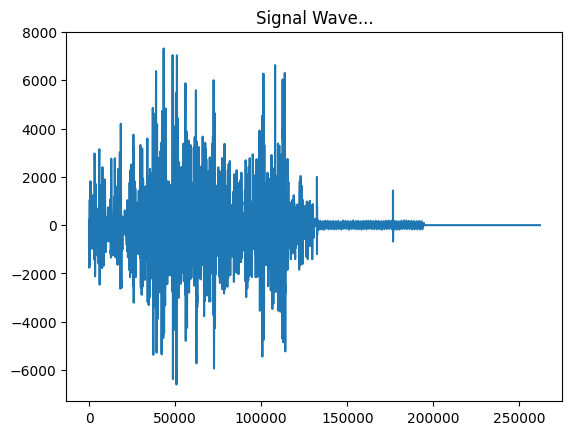

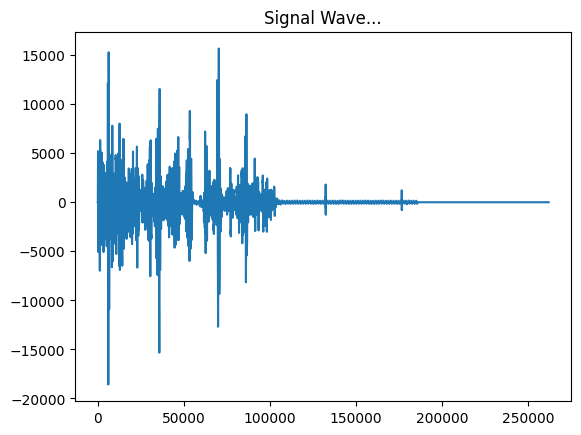

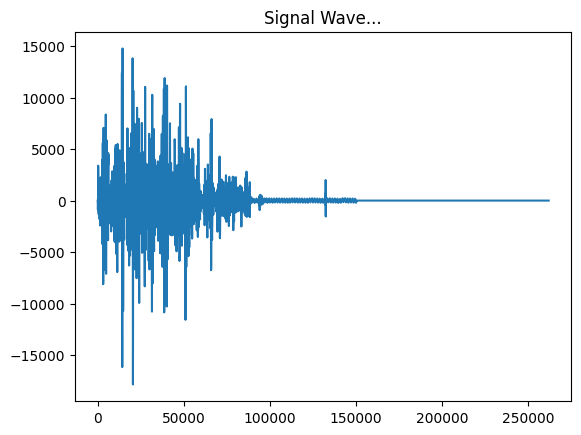

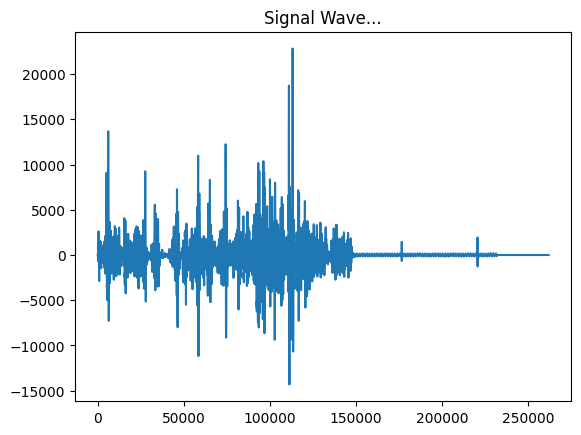

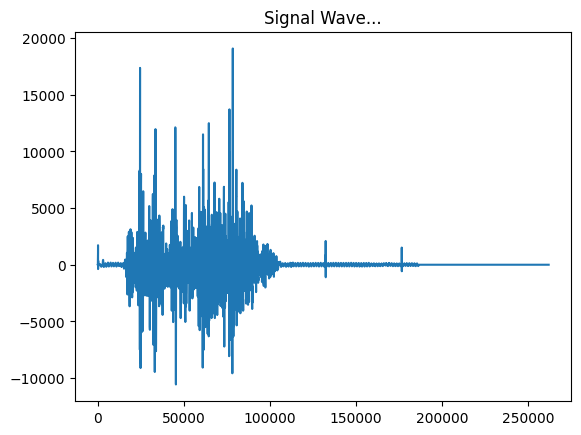

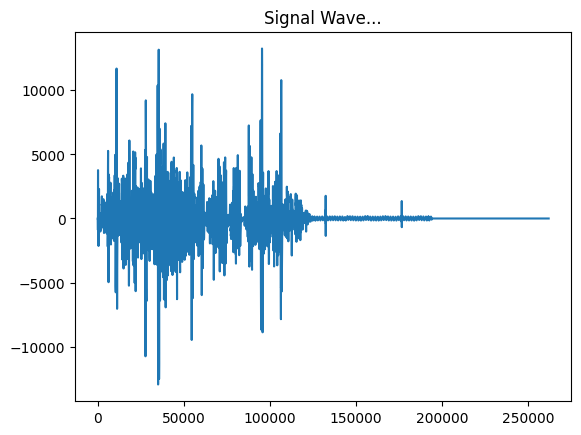

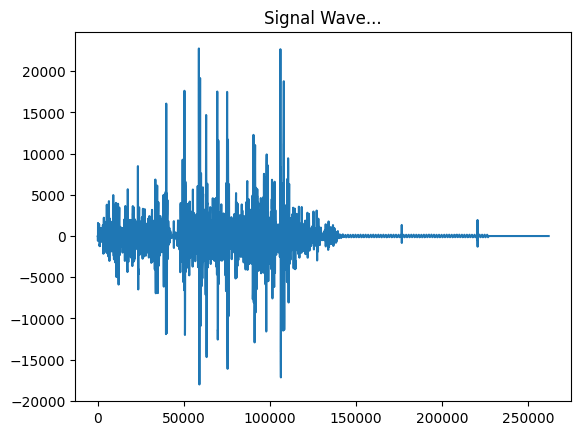

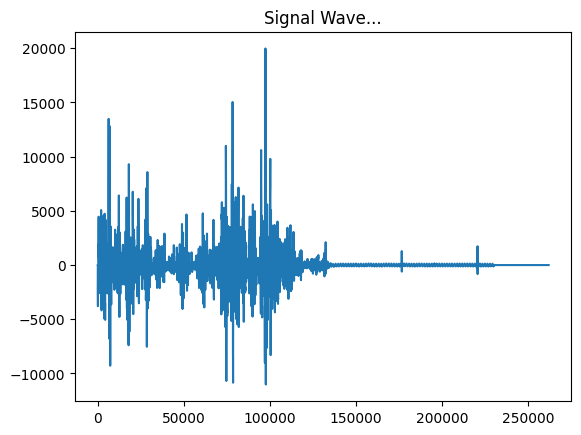

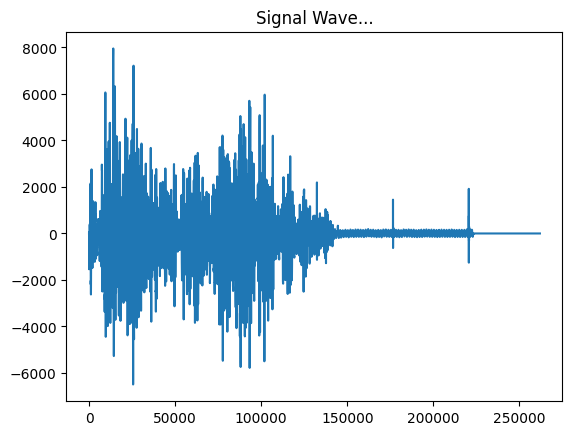

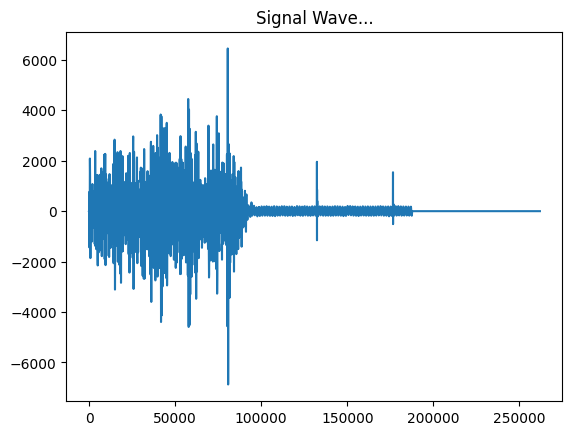

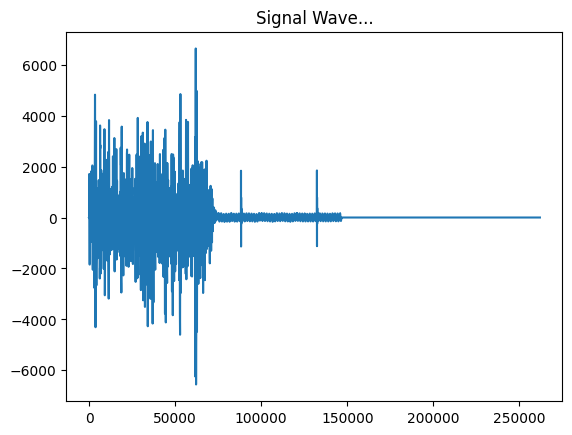

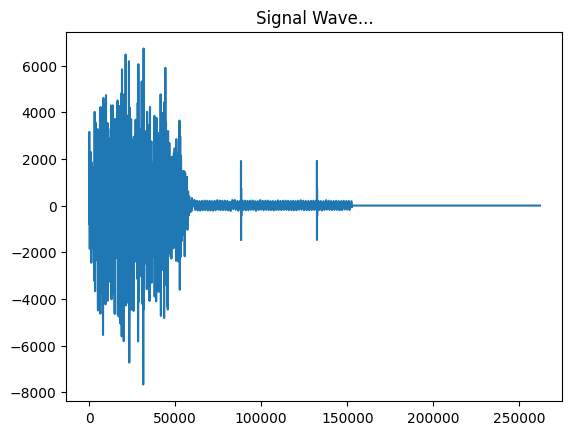

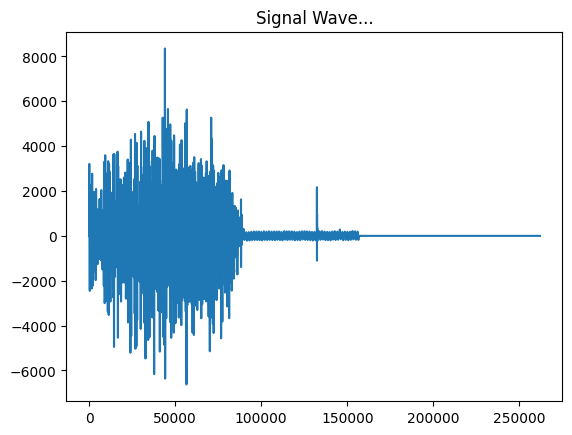

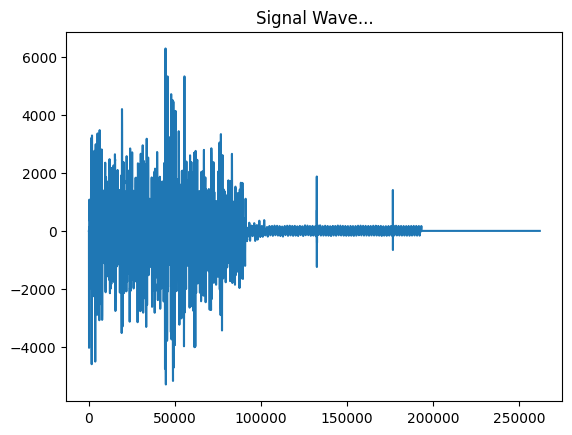

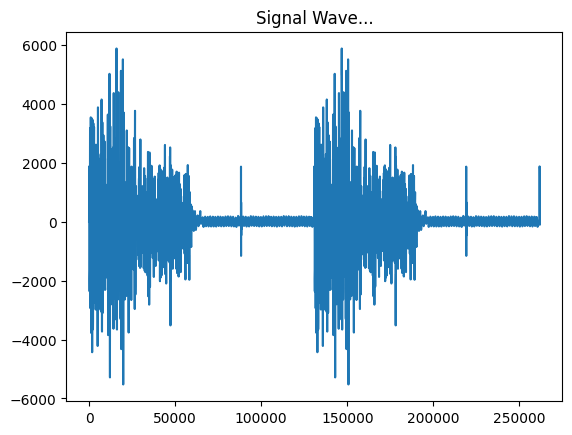

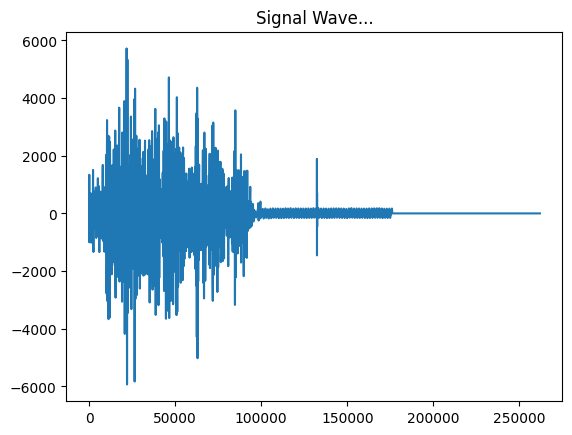

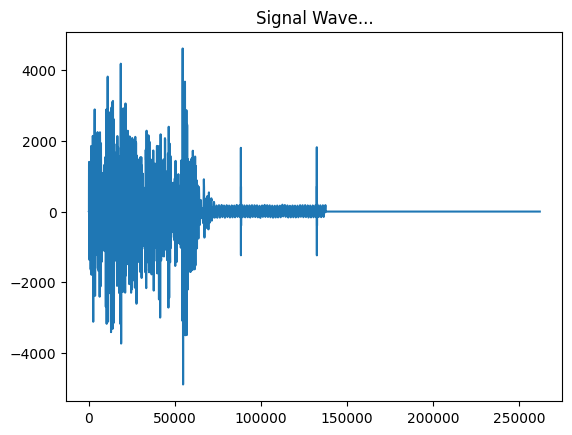

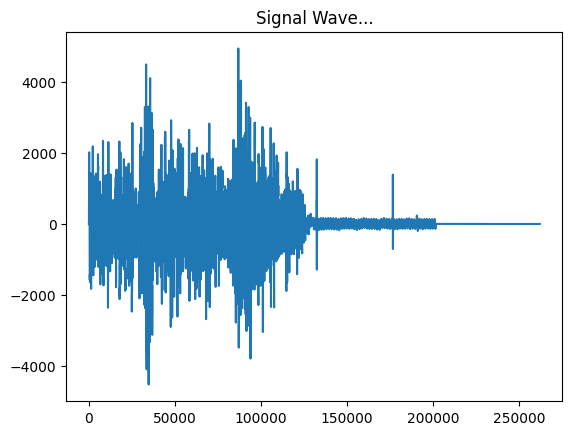

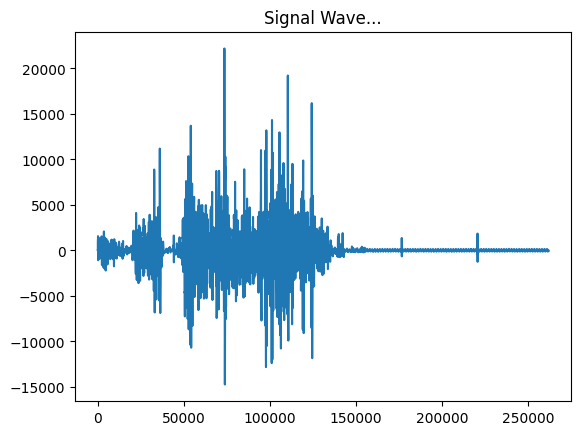

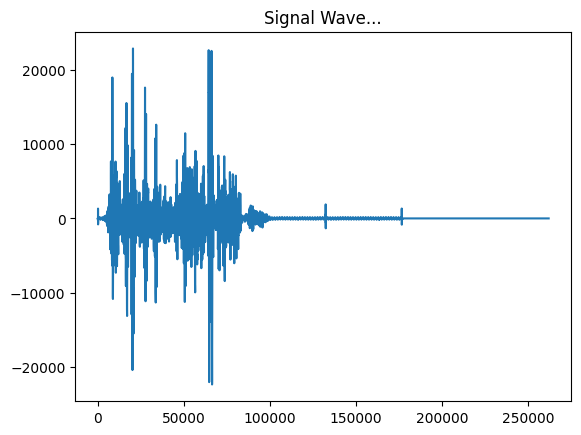

In [11]:
visualize(new_siglist)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(new_siglist, label, test_size=0.4, random_state=5)

print('fitting...')
clf = SVC(C=600, gamma=100)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("acc=%0.3f" % acc)

fitting...
acc=0.500


In [21]:
def extract_frequency(signal):
    # print(0)
    sp = np.fft.fft(signal, SIGNAL_LENGTH, 0)
    freq = np.fft.fftfreq(signal.shape[-1])
    # print(1)
    return sp, freq

sp_list = []

for sig in new_siglist:
    sp, freq = extract_frequency(sig)
    sp_list.append(sp.real)
    # plt.figure(1)
    # plt.plot(freq, sp.real)
    # plt.show()
    # print(2)

sp_list = np.array(sp_list)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(sp_list, label, test_size=0.4, random_state=5)

print('fitting...')
clf = SVC(C=60, gamma=10)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("acc=%0.3f" % acc)

fitting...
acc=0.500
